# CS 520 Project 3
Tejaswi Tripathi tt507
\
Contributions:

* []
* []

Ridwanur Sarder rrs148
\
Contributions:

* []
* []

Collaborated on all else.
\
**Note: writeup & analysis at the bottom!!!!!**

# Board Creation

In [4]:
import random

# random.seed(42)

d = 30
#alpha = 0.2 #constant for rat radar sensitivity


#Helper method to check neighbors in board initialization
def checkNeighbors(grid, r, c, a):
  return [grid[r-1][c],grid[r+1][c],grid[r][c-1],grid[r][c+1]].count(a)

#Create new board with given edge length
def createBoard(d):
  grid = [[0 for _ in range(d+2)] for _ in range(d+2)]

  for j in range(d+2):
    grid[0][j] = 2
    grid[d+1][j] = 2
  for i in range(d+2):
    grid[i][0] = 2
    grid[i][d+1] = 2
  x = random.randint(1, d)
  y = random.randint(1, d)

  fringe = []
  fringe.append((x,y))

  deadEnds = []

  while len(fringe) > 0:
    curr = random.choice(fringe)
    fringe.remove(curr)
    r, c = curr[0], curr[1]
    if checkNeighbors(grid, r, c, 1) > 1:
      continue
    grid[r][c] = 1
    up = (r-1, c)
    down = (r+1, c)
    left = (r, c-1)
    right = (r, c+1)
    deadEnd = True
    for elt in [up, down, left, right]:
      if grid[elt[0]][elt[1]] == 0:
        numOpenNeighbors = checkNeighbors(grid, elt[0], elt[1], 1)
        if numOpenNeighbors == 1:
          deadEnd = False
          fringe.append(elt)
    if deadEnd:
      deadEnds.append(curr)

  for elt in deadEnds:
    if grid[elt[0]][elt[1]] == 2:
      deadEnds.remove(elt)
      continue
    numOpenNeighbors = checkNeighbors(grid, elt[0], elt[1], 1)
    if numOpenNeighbors > 1:
      deadEnds.remove(elt)

  newList = random.sample(deadEnds, len(deadEnds) // 2)
  for elt in newList:
    r = elt[0]
    c = elt[1]
    up = (r-1, c)
    down = (r+1, c)
    left = (r, c-1)
    right = (r, c+1)
    neighbors = [up,down,left,right]
    neighbors = [elt for elt in neighbors if grid[elt[0]][elt[1]] == 0]
    if neighbors == []:
      continue
    curr = random.choice(neighbors)
    grid[curr[0]][curr[1]] = 1

  for j in range(d+2):
    grid[0][j] = 0
    grid[d+1][j] = 0
  for i in range(d+2):
    grid[i][0] = 0
    grid[i][d+1] = 0
  return grid

# Rat init
def rat_init(grid):
  ratLoc = (random.randint(1, d), random.randint(1, d))
  while grid[ratLoc[0]][ratLoc[1]] == 0:
    ratLoc = (random.randint(1, d), random.randint(1, d))
  return ratLoc

# Bot init
def bot_init(grid):
  botLoc = (random.randint(1, d), random.randint(1, d))
  while grid[botLoc[0]][botLoc[1]] == 0:
    botLoc = (random.randint(1, d), random.randint(1, d))
  return botLoc

def location_init(grid):
  botLoc = bot_init(grid)
  ratLoc = rat_init(grid)
  while(ratLoc == botLoc):
    ratLoc = rat_init(grid)
  return botLoc, ratLoc

def grid_set_locs(grid, botLoc, ratLoc):
  grid[botLoc[0]][botLoc[1]] = 3
  grid[ratLoc[0]][ratLoc[1]] = 2

In [5]:
import matplotlib.pyplot as plt
import numpy as np

color_map_3 = {
    0: 'black', #blocked
    1: 'white', #open
    2: 'red', #rat
    3: 'green', #agent
}

color_map_4 = {
    0: 'black', #blocked
    1: 'white', #open
    2: 'red', #rat
    3: 'green', #agent
    4: 'blue', #path
}

def visualizeGrid(color_map, grid):
    fig, ax = plt.subplots()

    for i in range(len(grid)):
        for j in range(len(grid[i])):
            ax.add_patch(plt.Rectangle((j, i), 1, 1, facecolor=color_map[grid[i][j]]))

    ax.set_xlim(0, len(grid[0]))
    ax.set_ylim(0, len(grid))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

    plt.gca().invert_yaxis()
    plt.show()

def probabiliyHeatmap(prb_grid):
  plt.imshow(prb_grid, cmap='viridis', interpolation='nearest')
  plt.colorbar()  # Add a colorbar to show probability values
  plt.title('Heatmap of Probabilities')
  plt.show()

In [6]:
grid = createBoard(d)
botLoc, ratLoc = location_init(grid)
# grid_set_locs(grid, botLoc, ratLoc)
# visualizeGrid(color_map_3, grid)

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import copy

# Bot Loop Code

In [8]:
import math

# sense surroundings for how many are currently blocked
def check_surroundings(grid, botCurrLoc):
  return [
      grid[botCurrLoc[0] + 1][botCurrLoc[1] + 1],
      grid[botCurrLoc[0]][botCurrLoc[1] + 1],
      grid[botCurrLoc[0] + 1][botCurrLoc[1]],
      grid[botCurrLoc[0] + 1][botCurrLoc[1] - 1],
      grid[botCurrLoc[0] - 1][botCurrLoc[1] + 1],
      grid[botCurrLoc[0] - 1][botCurrLoc[1]],
      grid[botCurrLoc[0]][botCurrLoc[1] - 1],
      grid[botCurrLoc[0] - 1][botCurrLoc[1]  - 1],
      ].count(0)

#manhattan helper method
def manhattan_distance(loc1, loc2):
    return abs(loc1[0] - loc2[0]) + abs(loc1[1] - loc2[1])

# space rat detector, returns distance on success, returns -1 otherwise
def check_rat(grid, botCurrLoc, ratLoc, alpha):
  distance = manhattan_distance(botCurrLoc, ratLoc)
  probability = math.exp(-alpha * (distance - 1))
  rand = random.random()
  # print((rand, probability))
  if rand < probability:
    return True
  return False

direction_map = {
    'up': (-1, 0),
    'down': (1, 0),
    'left': (0, -1),
    'right': (0, 1)
}

# move, returns location after moving and adjusts grid accordingly on success
def move_Bot(grid, botCurrLoc, dir):
  move_x, move_y = direction_map[dir]
  destination_row, destination_col = botCurrLoc[0] + move_x, botCurrLoc[1] + move_y
  # print(f"{botCurrLoc} moving {move_x,move_y} to {destination_row,destination_col}")
  if grid[destination_row][destination_col] != 0:
    grid[botCurrLoc[0]][botCurrLoc[1]] = 4
    grid[destination_row][destination_col] = 3
    return (destination_row, destination_col), True
  else:
    # print(f"Can't move {dir} to {destination_row, destination_col}")
    return botCurrLoc, False

# shortest path method
def shortest_path(grid, botLoc, dest, avoidVisited=False):
  fringe = []
  fringe.append(botLoc)

  closed_set = {}
  prev = {}
  prev[botLoc] = None

  while len(fringe) > 0:
      curr1 = fringe.pop(0)
      if curr1 == dest:
          break

      if curr1 not in closed_set:
          closed_set.update({curr1: 1})
          r1, c1 = curr1[0], curr1[1]
          neighbors1 = [(r1-1, c1),(r1+1, c1),(r1, c1-1),(r1, c1+1)]
          for elt in neighbors1:
              if grid[elt[0]][elt[1]] != 0 and elt not in closed_set:
                  # if avoidVisited:
                  #   continue
                  fringe.append(elt)
                  prev[elt] = curr1

  path = []
  curr = dest
  try:
      path.append(curr)
      curr = prev[curr]
  except:
      return False
  while curr is not None:
      path.append(curr)
      curr = prev[curr]
  return path[::-1]


In [9]:
# Probability grids

def update_probabilities(grid, probability_grid, botCurrLoc, alpha, ping):
  for r in range(1, len(probability_grid) - 1):
    for c in range(1, len(probability_grid[r]) - 1):
      manhattan_distance_from_bot = manhattan_distance((r,c), botCurrLoc)
      if manhattan_distance_from_bot == 0:
          probability_grid[r][c] = 0
      if(ping):
        probability_grid[r][c] *= math.exp(-alpha*(manhattan_distance_from_bot-1))
      else:
        probability_grid[r][c] *= (1-math.exp(-alpha*(manhattan_distance_from_bot)))

  totalPrb = sum(sum(row) for row in probability_grid)
  probability_grid = [[x/totalPrb for x in row] for row in probability_grid]
  # for row in knowledgeBase:
  #   print(row)
  totalPrb = sum(sum(row) for row in probability_grid) # at this point it should be 1
  return probability_grid

In [10]:
# Ping code
def ping(alpha, botLoc, ratLoc):
  distance = manhattan_distance(botLoc, ratLoc)
  probability = math.exp(-alpha * (distance - 1))
  if random.random() < probability:
    return 1
  return 0

In [11]:
# Utitilty function
def utility(theta_0, theta_1, p, d):
  return theta_0*p - theta_1*d

def get_middle_30x30(grid):
  return [row[1:-1] for row in grid[1:-1]]

In [43]:
# Phase 2 code
def phase_2(grid, botLoc, ratLoc, alpha, pathSoFar, visited, probability_grid, num_moves_list, bot_kb_list, rat_kb_list):

  prob_grid_3 = np.zeros((32,32))
  prob_grid_3[botLoc[0]][botLoc[1]] = 1


  num_moves = 0
  num_pings = 0
  t = 0
  success = False
  distanceFromRat = manhattan_distance(botLoc, ratLoc)
  count_further = 0
  len_path = 15
  # alternateMarker = True
  count = 0

  while botLoc != ratLoc:
    # ping = ping(alpha, botLoc, ratLoc)

    num_ping_attempts = math.ceil(10 * math.exp(-13 * np.max(probability_grid)))
    for i in range(num_ping_attempts):
        probability_grid = update_probabilities(grid, probability_grid, botLoc, alpha, ping(alpha, botLoc, ratLoc))
        num_pings += 1
        t += 1

    utilities = {}
    # theta_1 = np.max(probability_grid)
    for i in range(len(probability_grid)):
      for j in range(len(probability_grid[i])):
        if grid[i][j] == 0:
          utilities[(i,j)] = -100000
          continue
        d = manhattan_distance((i,j), botLoc)
        utilities[(i,j)] = utility(1, 10**(-8), probability_grid[i][j], d)
    # print(max(utilities))
    # dest = max({k: v for k, v in utilities.values() if k not in visited})           # accounting for visited cells
    dest = max((k for k in utilities if k not in visited), key=utilities.get, default=None)
    path = shortest_path(grid, botLoc, dest)
    while not path:
      utilities.pop(dest)
      dest = max((k for k in utilities if k not in visited), key=utilities.get, default=None)
      # dest = max({k: v for k, v in utilities.items() if k not in visited})
      path = shortest_path(grid, botLoc, dest)


    # print(visited)
    len_path = len(path)

    if len_path > 25:
      path = path[:max(2, len_path // 2)]
    num_moves += len(path)
    t += len(path)
    dest = path[-1]

    visited.add(dest)

    prob_grid_3[botLoc[0]][botLoc[1]] = 0
    botLoc = dest
    prob_grid_3[botLoc[0]][botLoc[1]] = 1

    pathSoFar += path
    newDistanceFromRat = manhattan_distance(botLoc, ratLoc)

    for i in path:
      grid[i[0]][i[1]] = 4

    grid[botLoc[0]][botLoc[1]] = 3
    grid[ratLoc[0]][ratLoc[1]] = 2
    # visualizeGrid(color_map_4, grid)
    if count >= num_ping_attempts:
      alternateMarker = True
      count = 0

    num_moves_list.append(num_moves)
    bot_kb_temp = np.array(get_middle_30x30(prob_grid_3))
    bot_kb_temp = bot_kb_temp.flatten()
    bot_kb_list = np.append(bot_kb_list, bot_kb_temp, axis=0)
    for i in range(len(num_moves_list)):
      num_moves_list[i] = num_moves - num_moves_list[i]

    rat_kb_temp = np.array(get_middle_30x30(probability_grid))
    rat_kb_temp = rat_kb_temp.flatten()
    rat_kb_list = np.append(rat_kb_list, rat_kb_temp, axis=0)

    count += 1


  success = True

  return num_moves, num_moves_list, bot_kb_list, rat_kb_list

In [44]:
import pandas as pd

def upgraded_bot_loop(grid, botLoc, ratLoc, alpha):
  prob_grid_2 = copy.deepcopy(grid)
  numberPossibleCells = sum(row.count(1) for row in prob_grid_2)
  for r in range(1, len(grid) - 1):
    for c in range(1, len(grid[r]) - 1):
      if grid[r][c] != 0:
        prob_grid_2[r][c] = 1/numberPossibleCells
  prob_grid_3 = copy.deepcopy(prob_grid_2)

  num_moves_list = [0]

  bot_kb_list = np.array(get_middle_30x30(prob_grid_3))
  bot_kb_list = bot_kb_list.flatten()

  rat_kb_list = np.array(get_middle_30x30(prob_grid_2))
  rat_kb_list = rat_kb_list.flatten()


  bot2_grid = copy.deepcopy(grid)
  grid_set_locs(bot2_grid, botLoc, ratLoc)

  pings = []
  pos_x = []
  pos_y = []

  # df_p = pd.DataFrame(data = {'ping': [], 'pos_x': [], 'pos_y': []})

  botCurrLoc = botLoc
  botRelativeLoc = (0,0)

  knowledgeBase = set()

  for r in range(1, len(grid) - 1):
    for c in range(1, len(grid[r]) - 1):
      if grid[r][c] == 1:
        knowledgeBase.add((r, c))
  # print(knowledgeBase)

  # visualizeGrid(color_map_4, bot2_grid)

  phase1Done = False # Set to true when we know where bot is
  alternatingMarker = False
  t = 0

  pathSoFar = []
  visited = set()
  visited.add(botCurrLoc)

  lastStep = None

  num_moves = 0
  num_senses = 0
  num_pings = 0
  count_further = 0
  bot_kb_size = 0

  #phase 1 - identify where bot is
  while not phase1Done:
    if botCurrLoc == ratLoc:
      num_moves_list.append(num_moves)
      for i in range(len(num_moves_list)):
        num_moves_list[i] = num_moves - num_moves_list[i]

      bot_kb_temp = np.array(get_middle_30x30(prob_grid_3))
      bot_kb_temp = bot_kb_temp.flatten()
      bot_kb_list = np.append(bot_kb_list, bot_kb_temp, axis=0)


      rat_kb_temp = np.array(get_middle_30x30(prob_grid_2))
      rat_kb_temp = rat_kb_temp.flatten()
      rat_kb_list = np.append(rat_kb_list, rat_kb_temp, axis=0)
      return num_moves_list, bot_kb_list, rat_kb_list
      break

    t += 1
    if t > 300:
      raise Exception("Infinite Loop Found!")

    alternatingMarker = not alternatingMarker

    # alternate between checking surroundings and moving
    if alternatingMarker:
      num_senses += 1

      #check surroundings and adjust KB accordingly
      botSurroundingWalls = check_surroundings(bot2_grid, botCurrLoc)
      possibleLocations = set()
      for cell in knowledgeBase:
        r, c = cell
        cellSurroundingWalls = check_surroundings(bot2_grid, cell)
        if botSurroundingWalls == cellSurroundingWalls and bot2_grid[r][c] != 0:
          possibleLocations.add((r,c))
      knowledgeBase = possibleLocations
      if num_senses == 1:
        bot_kb_size = len(knowledgeBase) / numberPossibleCells

      for r in range(1, len(prob_grid_3) - 1):
        for c in range(1, len(prob_grid_3[r]) - 1):
          prob_grid_3[r][c] = 0
      for r, c in knowledgeBase:
        prob_grid_3[r][c] = 1 / len(knowledgeBase)


      if len(knowledgeBase) == 1: # we have found where we are
        # botCurrLoc = knowledgeBase.pop()
        phase1Done = True
        # visualizeGrid(color_map_4, bot2_grid)
        break
        if len(knowledgeBase) == len(possibleLocations):
        # print(knowledgeBase)
        # print(possibleLocations)
        # print(opposite)
          raise Exception("Infinite Loop Found!")

    else: #move bot
      num_moves += 1
      directionFreq = {'up': 0, 'down': 0, 'left': 0, 'right': 0}

      for loc in knowledgeBase:
        r, c = loc
        for direction, (dr, dc) in direction_map.items():
          newr, newc = r + dr, c + dc
          if bot2_grid[newr][newc] != 0:
            directionFreq[direction] += 1
      # print(directionFreq)
      maxDir = max(directionFreq, key=directionFreq.get)

      opposites_map = {'up': 'down', 'down': 'up', 'left': 'right', 'right': 'left'}
      opposite = opposites_map.get(lastStep, None)

      if opposite != None:
        directionFreqFiltered = {k: v for k, v in directionFreq.items() if k != opposite}
        # print(directionFreqFiltered)
        if any(directionFreqFiltered.values()):
          maxDir = max(directionFreqFiltered, key=directionFreqFiltered.get)
        else:
          maxDir = max(directionFreq, key=directionFreq.get) #can move back if other directions have no count

# direction_map = {
#     'up': (-1, 0),
#     'down': (1, 0),
#     'left': (0, -1),
#     'right': (0, 1)
# }

      pings.append(ping(alpha, botCurrLoc, ratLoc))                             # Ping!
      pos_x.append(botRelativeLoc[0] + direction_map[maxDir][0])
      pos_y.append(botRelativeLoc[1] + direction_map[maxDir][1])


      # new_row = pd.DataFrame({'ping': ping(alpha, botCurrLoc, ratLoc),
      #              'pos_x': botRelativeLoc[0] + direction_map[maxDir][0],
      #              'pos_y': botRelativeLoc[1] + direction_map[maxDir][1]
      #              })
      # df_p = pd.concat([df_p, new_row])
      num_pings += 1

      lastStep = maxDir

      newLocation, moveStatus = move_Bot(bot2_grid, botCurrLoc, maxDir)

      if moveStatus: #successful move
        botCurrLoc = newLocation

        pathSoFar.append(maxDir)
        visited.add(newLocation)

        newKnowledgeBase = set() # replace kb with entries that were okay to move in this direction
        for loc in knowledgeBase:
          r, c = loc
          dr, dc = direction_map[maxDir]
          newr, newc = r + dr, c + dc
          if bot2_grid[newr][newc] != 0:
            newKnowledgeBase.add((newr, newc))
        knowledgeBase = newKnowledgeBase
      else: #unsuccessful move
        newKnowledgeBase = set() # replace kb with entries that were blocked in this direction
        for loc in knowledgeBase:
          r, c = loc
          dr, dc = direction_map[maxDir]
          newr, newc = r + dr, c + dc
          if bot2_grid[newr][newc] == 0:
            newKnowledgeBase.add((r, c))
        knowledgeBase = newKnowledgeBase

      if len(knowledgeBase) == 1:
        # botCurrLoc = knowledgeBase.pop()
        visited.add(botCurrLoc)
        phase1Done = True
        # visualizeGrid(color_map_4, bot2_grid)
        break

  # Phase 2
  for i in range(len(pings) - 1, -1, -1):
    # j = botCurrLoc - (pos_x[i], pos_y[i])
    j = tuple(x - y for x, y in zip(botCurrLoc, (pos_x[i], pos_y[i])))
    prob_grid_2 = update_probabilities(bot2_grid, prob_grid_2, j, alpha, pings[i])

  utilities = {}
  # theta_1 = np.max(probability_grid)
  for i in range(len(prob_grid_2)):
    for j in range(len(prob_grid_2[i])):
      if grid[i][j] == 0:
        utilities[(i,j)] = -100000
        continue
      d = manhattan_distance((i,j), botLoc)
      utilities[(i,j)] = utility(1, 10**(-8), prob_grid_2[i][j], d)
  # print(max(utilities))
  # dest = max({k: v for k, v in utilities.values() if k not in visited})           # accounting for visited cells
  dest = max((k for k in utilities if k not in visited), key=utilities.get, default=None)
  path = shortest_path(grid, botLoc, dest)
  while not path:
    utilities.pop(dest)
    dest = max((k for k in utilities if k not in visited), key=utilities.get, default=None)
    # dest = max({k: v for k, v in utilities.items() if k not in visited})
    path = shortest_path(grid, botLoc, dest)

  dist_to_dest = manhattan_distance(botLoc, dest)

  rat_kb = copy.deepcopy(prob_grid_2)
  rat_kb = np.array(rat_kb)

  pathSoFar_2 = []
  num_moves_2 = 0

  num_moves_2, num_moves_list, bot_kb_list, rat_kb_list = phase_2(bot2_grid, botCurrLoc, ratLoc, alpha, pathSoFar_2, visited, prob_grid_2, num_moves_list, bot_kb_list, rat_kb_list)

  num_moves += num_moves_2

  # num_moves_list.apply(lambda x: num_moves - num_moves_list[i] for i in range(len(num_moves_list)))

  for i in range(len(num_moves_list)):
    num_moves_list[i] = num_moves - num_moves_list[i]

  # if success:
  #   print(f"Process completed in {t} timesteps, {num_moves} moves, and {num_pings} pings.")

  # print(pathSoFar_2)
  for i in pathSoFar_2:
    bot2_grid[i[0]][i[1]] = 4
  # if success:
  bot2_grid[botLoc[0]][botLoc[1]] = 3
  bot2_grid[ratLoc[0]][ratLoc[1]] = 2
  # visualizeGrid(color_map_4, bot2_grid)


  return num_moves_list, bot_kb_list, rat_kb_list



## Simulations (Training and Testing the Model)

In [45]:
import csv

alpha = 0.012

try:
  with open('matrix.csv', 'r') as file:
    reader = csv.reader(file)
    gridX = []
    for row in reader:
        gridX.append([int(x) for x in row])

except FileNotFoundError:
  gridX = createBoard(30)
  with open('matrix.csv', 'w', newline='') as file:
      writer = csv.writer(file)
      for row in gridX:
          writer.writerow(row)

numRounds = 1000
# numRounds = 2

try:
  df_data = pd.read_csv('simulation_data.csv')
  num_moves_all = df_data['num_moves'].to_numpy()
  input_list_full = df_data.drop('num_moves', axis=1).to_numpy()
  input_list_full = input_list_full.reshape(len(num_moves_all), 2, 30, 30)
  print("Data loaded from CSV.")
except FileNotFoundError:
  print("Data file not found, starting new simulations:")
  num_moves_all = np.array([])
  input_list_full = []
  for i in range(numRounds):
    grid_copy = copy.deepcopy(gridX)
    botLoc, ratLoc = location_init(gridX)

    try:
      num_moves_list, bot_kb_list, rat_kb_list = upgraded_bot_loop(gridX, botLoc, ratLoc, alpha)
    except:
      continue

    bot_kb_list = np.reshape(bot_kb_list, (len(num_moves_list), 30, 30))
    rat_kb_list = np.reshape(rat_kb_list, (len(num_moves_list), 30, 30))
    for k in range(len(bot_kb_list)):
        input_list_full.append([bot_kb_list[k], rat_kb_list[k]])
    for k in range(len(num_moves_list)):
        num_moves_all = np.append(num_moves_all, num_moves_list[k])

  input_list_full = np.array(input_list_full)
  input_list_full = input_list_full.reshape(len(num_moves_all), -1)
  df_data = pd.DataFrame(input_list_full)
  df_data['num_moves'] = num_moves_all
  df_data.to_csv('simulation_data.csv', index=False)
  print("Data saved to CSV.")

print(num_moves_all.shape)
print(input_list_full.shape)


Data file not found, starting new simulations:
Data saved to CSV.
(24564,)
(24564, 1800)


In [46]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(torch.tensor(input_list_full, dtype=torch.float32),
                        torch.tensor(num_moves_all, dtype=torch.float32))

train_size = int(0.75 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_inputs, train_targets = train_dataset[:]
test_inputs, test_targets = test_dataset[:]

train_inputs = train_inputs.reshape(train_inputs.shape[0], 2, 30, 30)

test_inputs = test_inputs.reshape(test_inputs.shape[0], 2, 30, 30)

input_tensor = torch.tensor(train_inputs, dtype=torch.float32)
input_tensor = input_tensor.view(-1, 2, 30, 30)
target_tensor = torch.tensor(train_targets, dtype=torch.float32).reshape(-1, 1)

input_test = torch.tensor(test_inputs, dtype=torch.float32)
input_test = input_test.view(-1, 2, 30, 30)
target_test = torch.tensor(test_targets, dtype=torch.float32).reshape(-1, 1)

print(input_tensor.shape)
print(target_tensor.shape)
print(input_test.shape)
print(target_test.shape)

<ipython-input-46-b3fb1350d99f>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(train_inputs, dtype=torch.float32)


torch.Size([18423, 2, 30, 30])
torch.Size([18423, 1])
torch.Size([6141, 2, 30, 30])
torch.Size([6141, 1])


<ipython-input-46-b3fb1350d99f>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_tensor = torch.tensor(train_targets, dtype=torch.float32).reshape(-1, 1)
<ipython-input-46-b3fb1350d99f>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_test = torch.tensor(test_inputs, dtype=torch.float32)
<ipython-input-46-b3fb1350d99f>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_test = torch.tensor(test_targets, dtype=torch.float32).reshape(-1, 1)


In [21]:
def get_batch( x, y, batch_size ):
  n = x.shape[0]

  batch_indices = random.sample( [ i for i in range(n) ], k = batch_size )

  x_batch = x[ batch_indices ]

  y_batch = y[ batch_indices ]

  return x_batch, y_batch

In [20]:
class ShipCNN(nn.Module):
  def __init__(self):
    super(ShipCNN, self).__init__()
    self.conv1 = nn.Conv2d(2, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(64 * 7 * 7, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 1)
    self.pool = nn.MaxPool2d(2, 2)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)

    x = x.view(-1, 64 * 7 * 7)

    x = self.fc1(x)
    x = self.relu(x)

    x = self.fc2(x)
    x = self.relu(x)

    x = self.fc3(x)
    return x

In [22]:
# load model

model = ShipCNN()
# model_2 = ShipCNN_2()

# model.load_state_dict(torch.load('shipcnn_model.pth'))

model.eval()
# model_2.eval()

ShipCNN(
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

In [23]:
# model = ShipCNN()
optimizer = optim.Adam(model.parameters(), lr=0.05, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
criterion = nn.L1Loss()

# optimizer_2 = optim.Adam(model_2.parameters(), lr=0.05, weight_decay=0.01)
# scheduler_2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_2, 'min', patience=3, factor=0.5)

In [51]:
epochs = 30
batch_size = 500
train_loss_list = []
test_loss_list = []
input_tensor_len = len(input_tensor)
num_batches = input_tensor_len // batch_size

for epoch in range(epochs):
  train_loss = 0
  test_loss = 0
  for batch in range(num_batches):
    x_batch, y_batch = get_batch(input_tensor, target_tensor, batch_size)
    model.train()
    optimizer.zero_grad()
    outputs = model(x_batch)
    loss = criterion(outputs, y_batch)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

    x_test, y_test = get_batch(input_test, target_test, 50)
    model.eval()
    with torch.no_grad():
      test_outputs = model(x_test)
      loss_t = criterion(test_outputs, y_test)
      test_loss += loss_t.item()

  print(f'Epoch [{epoch+1}/{epochs}], Average L1 Training Loss: {(train_loss / batch_size):.4f}')
  print(f'Epoch [{epoch+1}/{epochs}], Average L1 Testing Loss: {(test_loss / 50):.4f}')
  train_loss_list.append(train_loss / batch_size)
  test_loss_list.append(test_loss / 50)

# losses = pd.DataFrame({'train_loss': train_loss_list, 'test_loss': test_loss_list})
# losses.to_csv('losses.csv', index=False)

Epoch [1/30], Average L1 Training Loss: 8.8271
Epoch [1/30], Average L1 Testing Loss: 87.3178
Epoch [2/30], Average L1 Training Loss: 6.8812
Epoch [2/30], Average L1 Testing Loss: 70.5539
Epoch [3/30], Average L1 Training Loss: 6.8199
Epoch [3/30], Average L1 Testing Loss: 66.7198
Epoch [4/30], Average L1 Training Loss: 6.8930
Epoch [4/30], Average L1 Testing Loss: 65.8668
Epoch [5/30], Average L1 Training Loss: 6.8964
Epoch [5/30], Average L1 Testing Loss: 68.2573
Epoch [6/30], Average L1 Training Loss: 6.8814
Epoch [6/30], Average L1 Testing Loss: 67.4752
Epoch [7/30], Average L1 Training Loss: 6.8738
Epoch [7/30], Average L1 Testing Loss: 71.9429
Epoch [8/30], Average L1 Training Loss: 6.8932
Epoch [8/30], Average L1 Testing Loss: 67.1612
Epoch [9/30], Average L1 Training Loss: 6.8539
Epoch [9/30], Average L1 Testing Loss: 69.6714
Epoch [10/30], Average L1 Training Loss: 6.9586
Epoch [10/30], Average L1 Testing Loss: 70.4646
Epoch [11/30], Average L1 Training Loss: 6.9468
Epoch [11/

KeyboardInterrupt: 

In [52]:
torch.save(model.state_dict(), 'shipcnn_model.pth')


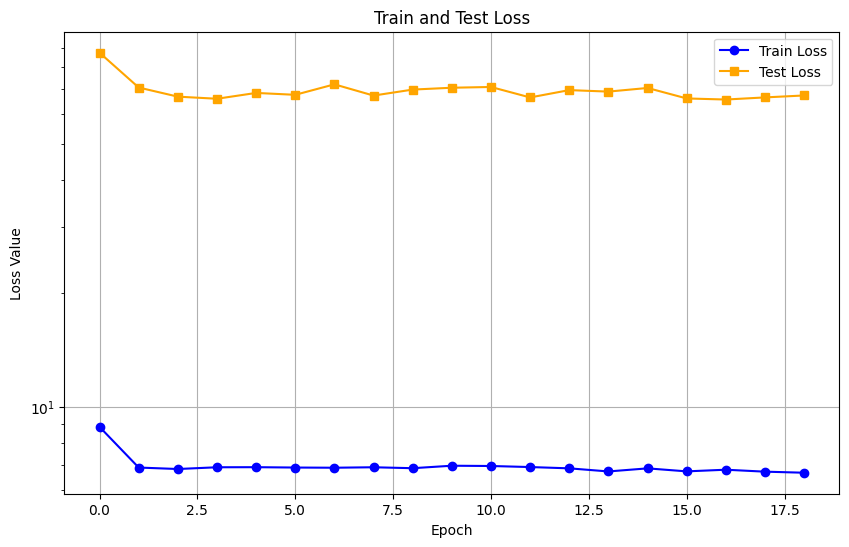

In [53]:
x_train_index = list(range(len(train_loss_list)))
x_test_index = list(range(len(test_loss_list)))

plt.figure(figsize=(10, 6))
plt.plot(x_train_index, train_loss_list, label='Train Loss', marker='o', color='blue')
plt.plot(x_test_index, test_loss_list, label='Test Loss', marker='s', color='orange')
plt.yscale("log")
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('Train and Test Loss')
plt.legend()
plt.grid(True)
plt.show()

## Loss Over Time

In [18]:
def predict_single_value(input_matrices):

  input_tensor = torch.tensor(input_matrices, dtype=torch.float32)
  input_tensor = input_tensor.unsqueeze(0)
  input_tensor = input_tensor.view(1, 2, 30, 30)

  model = ShipCNN()
  model.load_state_dict(torch.load("/content/shipcnn_model.pth"))
  model.eval()

  with torch.no_grad():
    prediction = model(input_tensor)

  predicted_value = prediction.item()

  return predicted_value

In [39]:
# Phase 2 code
def phase_2_sim(grid, botLoc, ratLoc, alpha, pathSoFar, visited, probability_grid, num_moves_list, bot_kb_list, rat_kb_list, gamma_list):

  prob_grid_3 = np.zeros((32,32))
  prob_grid_3[botLoc[0]][botLoc[1]] = 1

  num_moves_list_2 = []

  num_moves = 0
  num_pings = 0
  t = 0
  success = False
  distanceFromRat = manhattan_distance(botLoc, ratLoc)
  count_further = 0
  len_path = 15
  # alternateMarker = True
  count = 0

  while botLoc != ratLoc:
    # ping = ping(alpha, botLoc, ratLoc)

    num_ping_attempts = math.ceil(10 * math.exp(-13 * np.max(probability_grid)))
    for i in range(num_ping_attempts):
        probability_grid = update_probabilities(grid, probability_grid, botLoc, alpha, ping(alpha, botLoc, ratLoc))
        num_pings += 1
        t += 1

    utilities = {}
    input_matrices = np.append(get_middle_30x30(prob_grid_3), get_middle_30x30(probability_grid))
    gamma = predict_single_value(input_matrices)
    gamma_list.append(gamma)

    for i in range(len(probability_grid)):
      for j in range(len(probability_grid[i])):
        if grid[i][j] == 0:
          utilities[(i,j)] = -100000
          continue
        d = manhattan_distance((i,j), botLoc)
        utilities[(i,j)] = utility(1, 10**(-8), probability_grid[i][j], d)
    # print(max(utilities))
    # dest = max({k: v for k, v in utilities.values() if k not in visited})           # accounting for visited cells
    dest = max((k for k in utilities if k not in visited), key=utilities.get, default=None)
    path = shortest_path(grid, botLoc, dest)
    while not path:
      utilities.pop(dest)
      dest = max((k for k in utilities if k not in visited), key=utilities.get, default=None)
      # dest = max({k: v for k, v in utilities.items() if k not in visited})
      path = shortest_path(grid, botLoc, dest)


    # print(visited)
    len_path = len(path)

    if len_path > 25:
      path = path[:max(2, len_path // 2)]
    num_moves += len(path)
    t += len(path)
    dest = path[-1]

    visited.add(dest)                      # adding destination to visited

    prob_grid_3[botLoc[0]][botLoc[1]] = 0
    botLoc = dest
    prob_grid_3[botLoc[0]][botLoc[1]] = 1

    pathSoFar += path
    newDistanceFromRat = manhattan_distance(botLoc, ratLoc)

    for i in path:
      grid[i[0]][i[1]] = 4

    grid[botLoc[0]][botLoc[1]] = 3
    grid[ratLoc[0]][ratLoc[1]] = 2
    # visualizeGrid(color_map_4, grid)
    if count >= num_ping_attempts:
      alternateMarker = True
      count = 0

    num_moves_list_2.append(num_moves)
    bot_kb_temp = np.array(get_middle_30x30(prob_grid_3))
    bot_kb_temp = bot_kb_temp.flatten()
    bot_kb_list = np.append(bot_kb_list, bot_kb_temp, axis=0)
    for i in range(len(num_moves_list)):
      num_moves_list[i] = num_moves - num_moves_list[i]

    rat_kb_temp = np.array(get_middle_30x30(probability_grid))
    rat_kb_temp = rat_kb_temp.flatten()
    rat_kb_list = np.append(rat_kb_list, rat_kb_temp, axis=0)

    count += 1


  num_moves_list.extend(num_moves_list_2)
  success = True

  return num_moves, num_moves_list, bot_kb_list, rat_kb_list, gamma_list

In [40]:
import pandas as pd

def upgraded_bot_loop_sim(grid, botLoc, ratLoc, alpha):
  prob_grid_2 = copy.deepcopy(grid)
  numberPossibleCells = sum(row.count(1) for row in prob_grid_2)
  for r in range(1, len(grid) - 1):
    for c in range(1, len(grid[r]) - 1):
      if grid[r][c] != 0:
        prob_grid_2[r][c] = 1/numberPossibleCells
  prob_grid_3 = copy.deepcopy(prob_grid_2)

  num_moves_list = []

  bot_kb_list = np.array(get_middle_30x30(prob_grid_3))
  bot_kb_list = bot_kb_list.flatten()

  rat_kb_list = np.array(get_middle_30x30(prob_grid_2))
  rat_kb_list = rat_kb_list.flatten()

  gamma_list = []

  #prob grid 2 - rat location grid
  #prob grid 3 - bot location grid
  #grid - ship layout grid

  bot2_grid = copy.deepcopy(grid)
  grid_set_locs(bot2_grid, botLoc, ratLoc)

  pings = []
  pos_x = []
  pos_y = []

  # df_p = pd.DataFrame(data = {'ping': [], 'pos_x': [], 'pos_y': []})

  botCurrLoc = botLoc
  botRelativeLoc = (0,0)

  knowledgeBase = set()

  for r in range(1, len(grid) - 1):
    for c in range(1, len(grid[r]) - 1):
      if grid[r][c] == 1:
        knowledgeBase.add((r, c))
  # print(knowledgeBase)

  # visualizeGrid(color_map_4, bot2_grid)

  phase1Done = False # Set to true when we know where bot is
  alternatingMarker = False
  t = 0

  pathSoFar = []
  visited = set()
  visited.add(botCurrLoc)

  lastStep = None

  num_moves = 0
  num_senses = 0
  num_pings = 0
  count_further = 0
  bot_kb_size = 0

  #phase 1 - identify where bot is
  while not phase1Done:
    if botCurrLoc == ratLoc:
      num_moves_list.append(num_moves)
      for i in range(len(num_moves_list)):
        num_moves_list[i] = num_moves - num_moves_list[i]

      bot_kb_temp = np.array(get_middle_30x30(prob_grid_3))
      bot_kb_temp = bot_kb_temp.flatten()
      bot_kb_list = np.append(bot_kb_list, bot_kb_temp, axis=0)


      rat_kb_temp = np.array(get_middle_30x30(prob_grid_2))
      rat_kb_temp = rat_kb_temp.flatten()
      rat_kb_list = np.append(rat_kb_list, rat_kb_temp, axis=0)

      gamma_list.append(predict_single_value(np.append(bot_kb_temp, rat_kb_temp)))
      return num_moves_list, gamma_list
      break

    t += 1
    if t > 300:
      raise Exception("Infinite Loop Found!")

    alternatingMarker = not alternatingMarker

    # alternate between checking surroundings and moving
    if alternatingMarker:
      num_senses += 1

      #check surroundings and adjust KB accordingly
      botSurroundingWalls = check_surroundings(bot2_grid, botCurrLoc)
      possibleLocations = set()
      for cell in knowledgeBase:
        r, c = cell
        cellSurroundingWalls = check_surroundings(bot2_grid, cell)
        if botSurroundingWalls == cellSurroundingWalls and bot2_grid[r][c] != 0:
          possibleLocations.add((r,c))
      knowledgeBase = possibleLocations
      if num_senses == 1:
        bot_kb_size = len(knowledgeBase) / numberPossibleCells

      for r in range(1, len(prob_grid_3) - 1):
        for c in range(1, len(prob_grid_3[r]) - 1):
          prob_grid_3[r][c] = 0
      for r, c in knowledgeBase:
        prob_grid_3[r][c] = 1 / len(knowledgeBase)


      if len(knowledgeBase) == 1: # we have found where we are
        # botCurrLoc = knowledgeBase.pop()
        phase1Done = True
        # visualizeGrid(color_map_4, bot2_grid)
        break
        if len(knowledgeBase) == len(possibleLocations):
        # print(knowledgeBase)
        # print(possibleLocations)
        # print(opposite)
          raise Exception("Infinite Loop Found!")

    else: #move bot
      num_moves += 1
      directionFreq = {'up': 0, 'down': 0, 'left': 0, 'right': 0}

      for loc in knowledgeBase:
        r, c = loc
        for direction, (dr, dc) in direction_map.items():
          newr, newc = r + dr, c + dc
          if bot2_grid[newr][newc] != 0:
            directionFreq[direction] += 1
      # print(directionFreq)
      maxDir = max(directionFreq, key=directionFreq.get)

      opposites_map = {'up': 'down', 'down': 'up', 'left': 'right', 'right': 'left'}
      opposite = opposites_map.get(lastStep, None)

      if opposite != None:
        directionFreqFiltered = {k: v for k, v in directionFreq.items() if k != opposite}
        # print(directionFreqFiltered)
        if any(directionFreqFiltered.values()):
          maxDir = max(directionFreqFiltered, key=directionFreqFiltered.get)
        else:
          maxDir = max(directionFreq, key=directionFreq.get) #can move back if other directions have no count

# direction_map = {
#     'up': (-1, 0),
#     'down': (1, 0),
#     'left': (0, -1),
#     'right': (0, 1)
# }

      pings.append(ping(alpha, botCurrLoc, ratLoc))                             # Ping!
      pos_x.append(botRelativeLoc[0] + direction_map[maxDir][0])
      pos_y.append(botRelativeLoc[1] + direction_map[maxDir][1])


      # new_row = pd.DataFrame({'ping': ping(alpha, botCurrLoc, ratLoc),
      #              'pos_x': botRelativeLoc[0] + direction_map[maxDir][0],
      #              'pos_y': botRelativeLoc[1] + direction_map[maxDir][1]
      #              })
      # df_p = pd.concat([df_p, new_row])
      num_pings += 1

      lastStep = maxDir

      newLocation, moveStatus = move_Bot(bot2_grid, botCurrLoc, maxDir)

      if moveStatus: #successful move
        botCurrLoc = newLocation

        pathSoFar.append(maxDir)
        visited.add(newLocation)

        newKnowledgeBase = set() # replace kb with entries that were okay to move in this direction
        for loc in knowledgeBase:
          r, c = loc
          dr, dc = direction_map[maxDir]
          newr, newc = r + dr, c + dc
          if bot2_grid[newr][newc] != 0:
            newKnowledgeBase.add((newr, newc))
        knowledgeBase = newKnowledgeBase
      else: #unsuccessful move
        newKnowledgeBase = set() # replace kb with entries that were blocked in this direction
        for loc in knowledgeBase:
          r, c = loc
          dr, dc = direction_map[maxDir]
          newr, newc = r + dr, c + dc
          if bot2_grid[newr][newc] == 0:
            newKnowledgeBase.add((r, c))
        knowledgeBase = newKnowledgeBase

      if len(knowledgeBase) == 1:
        # botCurrLoc = knowledgeBase.pop()
        visited.add(botCurrLoc)
        phase1Done = True
        # visualizeGrid(color_map_4, bot2_grid)
        break

  # Phase 2
  for i in range(len(pings) - 1, -1, -1):
    # j = botCurrLoc - (pos_x[i], pos_y[i])
    j = tuple(x - y for x, y in zip(botCurrLoc, (pos_x[i], pos_y[i])))
    prob_grid_2 = update_probabilities(bot2_grid, prob_grid_2, j, alpha, pings[i])

  utilities = {}
  # theta_1 = np.max(probability_grid)
  for i in range(len(prob_grid_2)):
    for j in range(len(prob_grid_2[i])):
      if grid[i][j] == 0:
        utilities[(i,j)] = -100000
        continue
      d = manhattan_distance((i,j), botLoc)
      utilities[(i,j)] = utility(1, 10**(-8), prob_grid_2[i][j], d)
  # print(max(utilities))
  # dest = max({k: v for k, v in utilities.values() if k not in visited})           # accounting for visited cells
  dest = max((k for k in utilities if k not in visited), key=utilities.get, default=None)
  path = shortest_path(grid, botLoc, dest)
  while not path:
    utilities.pop(dest)
    dest = max((k for k in utilities if k not in visited), key=utilities.get, default=None)
    # dest = max({k: v for k, v in utilities.items() if k not in visited})
    path = shortest_path(grid, botLoc, dest)

  dist_to_dest = manhattan_distance(botLoc, dest)

  rat_kb = copy.deepcopy(prob_grid_2)
  rat_kb = np.array(rat_kb)

  pathSoFar_2 = []
  num_moves_2 = 0

  num_moves_2, num_moves_list, bot_kb_list, rat_kb_list, gamma_list = phase_2_sim(bot2_grid, botCurrLoc, ratLoc, alpha, pathSoFar_2, visited, prob_grid_2, num_moves_list, bot_kb_list, rat_kb_list, gamma_list)

  num_moves += num_moves_2

  # num_moves_list.apply(lambda x: num_moves - num_moves_list[i] for i in range(len(num_moves_list)))

  for i in range(len(num_moves_list)):
    num_moves_list[i] = num_moves - num_moves_list[i]

  # if success:
  #   print(f"Process completed in {t} timesteps, {num_moves} moves, and {num_pings} pings.")

  # print(pathSoFar_2)
  for i in pathSoFar_2:
    bot2_grid[i[0]][i[1]] = 4
  # if success:
  bot2_grid[botLoc[0]][botLoc[1]] = 3
  bot2_grid[ratLoc[0]][ratLoc[1]] = 2
  # visualizeGrid(color_map_4, bot2_grid)


  return num_moves, num_moves_list, gamma_list



In [57]:
num_moves_all_sim = np.array([])
gamma_list_full_sim = np.array([])

for i in range(200):
  grid_copy = copy.deepcopy(gridX)
  botLoc, ratLoc = location_init(gridX)

  try:
    num_moves, num_moves_list, gamma_list = upgraded_bot_loop_sim(gridX, botLoc, ratLoc, alpha)

  except:
    continue

  for k in range(len(num_moves_list)):
    num_moves_all_sim = np.append(num_moves_all_sim, num_moves_list[k])
  for k in range(len(gamma_list)):
    gamma_list_full_sim = np.append(gamma_list_full_sim, gamma_list[k])

print(num_moves_all_sim.shape)
print(gamma_list_full_sim.shape)

# df = pd.DataFrame({'num_moves': num_moves_all_sim, 'gamma': gamma_list_full_sim})
# df.to_csv('sim_data.csv', index=False)

<ipython-input-54-6c080aceff05>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/shipcnn_model.pth"))


(4690,)
(4690,)


In [45]:
import numpy as np

def calculate_partitioned_mae(num_moves_all_sim, gamma_list_full_sim):
  min_moves = np.min(num_moves_all_sim)
  max_moves = np.max(num_moves_all_sim)
  partition_edges = np.linspace(min_moves, max_moves, num=16)

  mae_vector = []
  for i in range(15):
    partition_indices = np.where((num_moves_all_sim >= partition_edges[i]) & (num_moves_all_sim < partition_edges[i + 1]))[0]

    gamma_values = gamma_list_full_sim[partition_indices]
    num_moves = num_moves_all_sim[partition_indices]
    mae = np.mean(np.abs(gamma_values - num_moves))
    mae_vector.append(mae)

  return mae_vector[::-1]


(291.0,	 104.5)	 Diff: 186.5)
(293.0,	 107.3)	 Diff: 185.7)
(276.0,	 106.7)	 Diff: 169.3)
(260.0,	 109.2)	 Diff: 150.8)
(245.0,	 110.1)	 Diff: 134.9)
(5.0,	 135.9)	 Diff: 130.9)
(232.0,	 106.3)	 Diff: 125.7)
(13.0,	 126.7)	 Diff: 113.7)
(22.0,	 134.8)	 Diff: 112.8)
(220.0,	 107.9)	 Diff: 112.1)
(218.0,	 109.5)	 Diff: 108.5)
(31.0,	 135.7)	 Diff: 104.7)
(215.0,	 116.5)	 Diff: 98.5)
(38.0,	 128.1)	 Diff: 90.1)
(211.0,	 126.3)	 Diff: 84.7)
(207.0,	 124.2)	 Diff: 82.8)
(43.0,	 121.7)	 Diff: 78.7)
(205.0,	 126.3)	 Diff: 78.7)
(49.0,	 126.9)	 Diff: 77.9)
(47.0,	 121.7)	 Diff: 74.7)
(202.0,	 128.7)	 Diff: 73.3)
(199.0,	 127.5)	 Diff: 71.5)
(193.0,	 129.7)	 Diff: 63.3)
(52.0,	 114.9)	 Diff: 62.9)
(105.0,	 166.1)	 Diff: 61.1)
(54.0,	 114.3)	 Diff: 60.3)
(185.0,	 128.7)	 Diff: 56.3)
(187.0,	 131.5)	 Diff: 55.5)
(179.0,	 130.7)	 Diff: 48.3)
(117.0,	 163.3)	 Diff: 46.3)
(69.0,	 110.0)	 Diff: 41.0)
(171.0,	 131.2)	 Diff: 39.8)
(150.0,	 111.3)	 Diff: 38.7)
(155.0,	 117.1)	 Diff: 37.9)
(84.0,	 112.7)

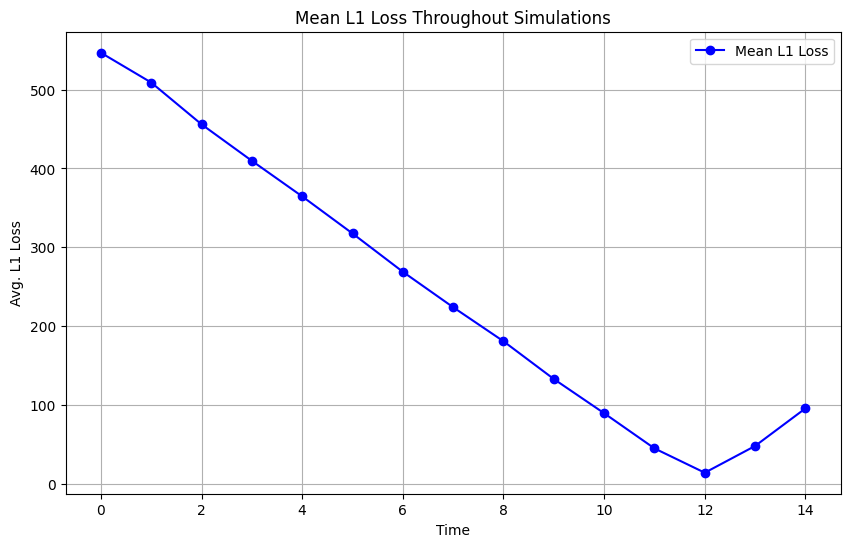

In [59]:
# print(num_moves_all_sim[:50])
# print(gamma_list_full_sim[:50])
paired_with_diff = [(a, b, b - a) for a, b in zip(num_moves_all_sim[50:100], gamma_list_full_sim[50:100])]
paired_with_diff = sorted(paired_with_diff, key=lambda item: abs(item[0] - item[1]), reverse=True)

for index, (a, b, diff) in enumerate(paired_with_diff, start=1):
    print(f"({a},\t {b:.1f})\t Diff: {abs(diff):.1f})")

mae_vector = calculate_partitioned_mae(num_moves_all_sim, gamma_list_full_sim)
# print(mae_vector)
target_index = list(range(len(mae_vector)))
# print(mae_vector)

plt.figure(figsize=(10, 6))
plt.plot(target_index, mae_vector, label='Mean L1 Loss', marker='o', color='blue')
# plt.yscale("log")
plt.xlabel('Time')
plt.ylabel('Avg. L1 Loss')
plt.title('Mean L1 Loss Throughout Simulations')
plt.legend()
plt.grid(True)
plt.show()

In [133]:
# def utility_nn(theta_0, theta_1, p, d, gamma):
#   return theta_0*p - theta_1*d + (math.exp(-p*abs(d-gamma)))/2

def utility_nn(theta_0, theta_1, p, d, gamma):
    """
    Compute the utility function with a smooth penalty for high `d` values.

    Parameters:
    - p (float): Positive contribution term.
    - d (float): Distance term to penalize.
    - gamma (float): Reference value for the penalty.
    - theta_0 (float): Weight for `p`.
    - theta_1 (float): Weight for `d`.
    - theta_2 (float): Weight for the penalty term.
    - alpha (float): Severity of the penalty.
    - beta (float): Steepness of the sigmoid for the penalty.

    Returns:
    - float: Computed utility.
    """
    # Compute base utility
    base_utility = theta_0 * p - theta_1 * d

    # Compute the threshold
    gamma_threshold = gamma / 2

    # Smooth penalty using a sigmoid
    penalty_weight = 1 / (1 + math.exp(-5 * (d - gamma_threshold)))

    # Smooth penalty term
    penalty = penalty_weight * (d - gamma_threshold) ** 2

    # Final utility
    return base_utility - 2 * penalty

In [98]:
# Phase 2 code
def phase_2_nn(grid, botLoc, ratLoc, alpha, pathSoFar, visited, probability_grid, num_moves_list, bot_kb_list, rat_kb_list, gamma_list):

  prob_grid_3 = np.zeros((32,32))
  prob_grid_3[botLoc[0]][botLoc[1]] = 1

  num_moves_list_2 = []

  num_moves = 0
  num_pings = 0
  t = 0
  success = False
  distanceFromRat = manhattan_distance(botLoc, ratLoc)
  count_further = 0
  len_path = 15
  # alternateMarker = True
  count = 0

  while botLoc != ratLoc:
    # ping = ping(alpha, botLoc, ratLoc)

    num_ping_attempts = math.ceil(10 * math.exp(-13 * np.max(probability_grid)))
    for i in range(num_ping_attempts):
        probability_grid = update_probabilities(grid, probability_grid, botLoc, alpha, ping(alpha, botLoc, ratLoc))
        num_pings += 1
        t += 1

    utilities = {}
    input_matrices = np.append(get_middle_30x30(prob_grid_3), get_middle_30x30(probability_grid))
    gamma = predict_single_value(input_matrices)
    gamma_list.append(gamma)

    for i in range(len(probability_grid)):
      for j in range(len(probability_grid[i])):
        if grid[i][j] == 0:
          utilities[(i,j)] = -100000
          continue
        d = manhattan_distance((i,j), botLoc)
        utilities[(i,j)] = utility_nn(1, 10**(-8), probability_grid[i][j], d, gamma)
    # print(max(utilities))
    # dest = max({k: v for k, v in utilities.values() if k not in visited})           # accounting for visited cells
    dest = max((k for k in utilities if k not in visited), key=utilities.get, default=None)
    path = shortest_path(grid, botLoc, dest)
    while not path:
      utilities.pop(dest)
      dest = max((k for k in utilities if k not in visited), key=utilities.get, default=None)
      # dest = max({k: v for k, v in utilities.items() if k not in visited})
      path = shortest_path(grid, botLoc, dest)


    # print(visited)
    len_path = len(path)

    if len_path > 25:
      path = path[:max(2, len_path // 2)]
    num_moves += len(path)
    t += len(path)
    dest = path[-1]

    visited.add(dest)                      # adding destination to visited

    prob_grid_3[botLoc[0]][botLoc[1]] = 0
    botLoc = dest
    prob_grid_3[botLoc[0]][botLoc[1]] = 1

    pathSoFar += path
    newDistanceFromRat = manhattan_distance(botLoc, ratLoc)

    for i in path:
      grid[i[0]][i[1]] = 4

    grid[botLoc[0]][botLoc[1]] = 3
    grid[ratLoc[0]][ratLoc[1]] = 2
    # visualizeGrid(color_map_4, grid)
    if count >= num_ping_attempts:
      alternateMarker = True
      count = 0

    num_moves_list_2.append(num_moves)
    bot_kb_temp = np.array(get_middle_30x30(prob_grid_3))
    bot_kb_temp = bot_kb_temp.flatten()
    bot_kb_list = np.append(bot_kb_list, bot_kb_temp, axis=0)
    for i in range(len(num_moves_list)):
      num_moves_list[i] = num_moves - num_moves_list[i]

    rat_kb_temp = np.array(get_middle_30x30(probability_grid))
    rat_kb_temp = rat_kb_temp.flatten()
    rat_kb_list = np.append(rat_kb_list, rat_kb_temp, axis=0)

    count += 1


  num_moves_list.extend(num_moves_list_2)
  success = True

  return num_moves, num_moves_list, bot_kb_list, rat_kb_list, gamma_list

In [128]:
import pandas as pd
import csv

with open('matrix.csv', 'r') as file:
    reader = csv.reader(file)
    gridX = []
    for row in reader:
        gridX.append([int(x) for x in row])

botLoc, ratLoc = location_init(gridX)


def upgraded_bot_loop_nn(grid, botLoc, ratLoc, alpha):
  prob_grid_2 = copy.deepcopy(grid)
  numberPossibleCells = sum(row.count(1) for row in prob_grid_2)
  for r in range(1, len(grid) - 1):
    for c in range(1, len(grid[r]) - 1):
      if grid[r][c] != 0:
        prob_grid_2[r][c] = 1/numberPossibleCells
  prob_grid_3 = copy.deepcopy(prob_grid_2)

  num_moves_list = []

  bot_kb_list = np.array(get_middle_30x30(prob_grid_3))
  bot_kb_list = bot_kb_list.flatten()

  rat_kb_list = np.array(get_middle_30x30(prob_grid_2))
  rat_kb_list = rat_kb_list.flatten()

  gamma_list = []

  #prob grid 2 - rat location grid
  #prob grid 3 - bot location grid
  #grid - ship layout grid

  bot2_grid = copy.deepcopy(grid)
  grid_set_locs(bot2_grid, botLoc, ratLoc)

  pings = []
  pos_x = []
  pos_y = []

  # df_p = pd.DataFrame(data = {'ping': [], 'pos_x': [], 'pos_y': []})

  botCurrLoc = botLoc
  botRelativeLoc = (0,0)

  knowledgeBase = set()

  for r in range(1, len(grid) - 1):
    for c in range(1, len(grid[r]) - 1):
      if grid[r][c] == 1:
        knowledgeBase.add((r, c))
  # print(knowledgeBase)

  # visualizeGrid(color_map_4, bot2_grid)

  phase1Done = False # Set to true when we know where bot is
  alternatingMarker = False
  t = 0

  pathSoFar = []
  visited = set()
  visited.add(botCurrLoc)

  lastStep = None

  num_moves = 0
  num_senses = 0
  num_pings = 0
  count_further = 0
  bot_kb_size = 0

  #phase 1 - identify where bot is
  while not phase1Done:
    if botCurrLoc == ratLoc:
      num_moves_list.append(num_moves)
      for i in range(len(num_moves_list)):
        num_moves_list[i] = num_moves - num_moves_list[i]

      bot_kb_temp = np.array(get_middle_30x30(prob_grid_3))
      bot_kb_temp = bot_kb_temp.flatten()
      bot_kb_list = np.append(bot_kb_list, bot_kb_temp, axis=0)


      rat_kb_temp = np.array(get_middle_30x30(prob_grid_2))
      rat_kb_temp = rat_kb_temp.flatten()
      rat_kb_list = np.append(rat_kb_list, rat_kb_temp, axis=0)

      gamma_list.append(predict_single_value(np.append(bot_kb_temp, rat_kb_temp)))
      return num_moves_list, gamma_list
      break

    t += 1
    if t > 300:
      raise Exception("Infinite Loop Found!")

    alternatingMarker = not alternatingMarker

    # alternate between checking surroundings and moving
    if alternatingMarker:
      num_senses += 1

      #check surroundings and adjust KB accordingly
      botSurroundingWalls = check_surroundings(bot2_grid, botCurrLoc)
      possibleLocations = set()
      for cell in knowledgeBase:
        r, c = cell
        cellSurroundingWalls = check_surroundings(bot2_grid, cell)
        if botSurroundingWalls == cellSurroundingWalls and bot2_grid[r][c] != 0:
          possibleLocations.add((r,c))
      knowledgeBase = possibleLocations
      if num_senses == 1:
        bot_kb_size = len(knowledgeBase) / numberPossibleCells

      for r in range(1, len(prob_grid_3) - 1):
        for c in range(1, len(prob_grid_3[r]) - 1):
          prob_grid_3[r][c] = 0
      for r, c in knowledgeBase:
        prob_grid_3[r][c] = 1 / len(knowledgeBase)


      if len(knowledgeBase) == 1: # we have found where we are
        # botCurrLoc = knowledgeBase.pop()
        phase1Done = True
        # visualizeGrid(color_map_4, bot2_grid)
        break
        if len(knowledgeBase) == len(possibleLocations):
        # print(knowledgeBase)
        # print(possibleLocations)
        # print(opposite)
          raise Exception("Infinite Loop Found!")

    else: #move bot
      num_moves += 1
      directionFreq = {'up': 0, 'down': 0, 'left': 0, 'right': 0}

      for loc in knowledgeBase:
        r, c = loc
        for direction, (dr, dc) in direction_map.items():
          newr, newc = r + dr, c + dc
          if bot2_grid[newr][newc] != 0:
            directionFreq[direction] += 1
      # print(directionFreq)
      maxDir = max(directionFreq, key=directionFreq.get)

      opposites_map = {'up': 'down', 'down': 'up', 'left': 'right', 'right': 'left'}
      opposite = opposites_map.get(lastStep, None)

      if opposite != None:
        directionFreqFiltered = {k: v for k, v in directionFreq.items() if k != opposite}
        # print(directionFreqFiltered)
        if any(directionFreqFiltered.values()):
          maxDir = max(directionFreqFiltered, key=directionFreqFiltered.get)
        else:
          maxDir = max(directionFreq, key=directionFreq.get) #can move back if other directions have no count

# direction_map = {
#     'up': (-1, 0),
#     'down': (1, 0),
#     'left': (0, -1),
#     'right': (0, 1)
# }

      pings.append(ping(alpha, botCurrLoc, ratLoc))                             # Ping!
      pos_x.append(botRelativeLoc[0] + direction_map[maxDir][0])
      pos_y.append(botRelativeLoc[1] + direction_map[maxDir][1])

      num_pings += 1

      lastStep = maxDir

      newLocation, moveStatus = move_Bot(bot2_grid, botCurrLoc, maxDir)

      if moveStatus: #successful move
        botCurrLoc = newLocation

        pathSoFar.append(maxDir)
        visited.add(newLocation)

        newKnowledgeBase = set() # replace kb with entries that were okay to move in this direction
        for loc in knowledgeBase:
          r, c = loc
          dr, dc = direction_map[maxDir]
          newr, newc = r + dr, c + dc
          if bot2_grid[newr][newc] != 0:
            newKnowledgeBase.add((newr, newc))
        knowledgeBase = newKnowledgeBase
      else: #unsuccessful move
        newKnowledgeBase = set() # replace kb with entries that were blocked in this direction
        for loc in knowledgeBase:
          r, c = loc
          dr, dc = direction_map[maxDir]
          newr, newc = r + dr, c + dc
          if bot2_grid[newr][newc] == 0:
            newKnowledgeBase.add((r, c))
        knowledgeBase = newKnowledgeBase

      if len(knowledgeBase) == 1:
        # botCurrLoc = knowledgeBase.pop()
        visited.add(botCurrLoc)
        phase1Done = True
        # visualizeGrid(color_map_4, bot2_grid)
        break

  # Phase 2
  for i in range(len(pings) - 1, -1, -1):
    # j = botCurrLoc - (pos_x[i], pos_y[i])
    j = tuple(x - y for x, y in zip(botCurrLoc, (pos_x[i], pos_y[i])))
    prob_grid_2 = update_probabilities(bot2_grid, prob_grid_2, j, alpha, pings[i])

  utilities = {}
  # theta_1 = np.max(probability_grid)
  for i in range(len(prob_grid_2)):
    for j in range(len(prob_grid_2[i])):
      if grid[i][j] == 0:
        utilities[(i,j)] = -100000
        continue
      d = manhattan_distance((i,j), botLoc)
      utilities[(i,j)] = utility(1, 10**(-8), prob_grid_2[i][j], d)
  # print(max(utilities))
  # dest = max({k: v for k, v in utilities.values() if k not in visited})           # accounting for visited cells
  dest = max((k for k in utilities if k not in visited), key=utilities.get, default=None)
  path = shortest_path(grid, botLoc, dest)
  while not path:
    utilities.pop(dest)
    dest = max((k for k in utilities if k not in visited), key=utilities.get, default=None)
    # dest = max({k: v for k, v in utilities.items() if k not in visited})
    path = shortest_path(grid, botLoc, dest)

  dist_to_dest = manhattan_distance(botLoc, dest)

  rat_kb = copy.deepcopy(prob_grid_2)
  rat_kb = np.array(rat_kb)

  pathSoFar_2 = []
  num_moves_2 = 0

  num_moves_2, num_moves_list, bot_kb_list, rat_kb_list, gamma_list = phase_2_nn(bot2_grid, botCurrLoc, ratLoc, alpha, pathSoFar_2, visited, prob_grid_2, num_moves_list, bot_kb_list, rat_kb_list, gamma_list)

  num_moves += num_moves_2

  # num_moves_list.apply(lambda x: num_moves - num_moves_list[i] for i in range(len(num_moves_list)))

  for i in range(len(num_moves_list)):
    num_moves_list[i] = num_moves - num_moves_list[i]

  # if success:
  #   print(f"Process completed in {t} timesteps, {num_moves} moves, and {num_pings} pings.")

  # print(pathSoFar_2)
  for i in pathSoFar_2:
    bot2_grid[i[0]][i[1]] = 4
  # if success:
  bot2_grid[botLoc[0]][botLoc[1]] = 3
  bot2_grid[ratLoc[0]][ratLoc[1]] = 2
  # visualizeGrid(color_map_4, bot2_grid)


  return num_moves

num_moves = upgraded_bot_loop_nn(gridX, botLoc, ratLoc, 0.012)
print(num_moves)

<ipython-input-18-6c080aceff05>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/shipcnn_model.pth"))


108


In [134]:
num_moves_baseline_list = []
num_moves_nn_list = []

alpha = 0.012

for i in range(200):
  grid_copy = copy.deepcopy(gridX)
  botLoc, ratLoc = location_init(gridX)


  try:
    num_moves_baseline, num_moves_list, gamma_list = upgraded_bot_loop_sim(gridX, botLoc, ratLoc, alpha)
    num_moves_nn = upgraded_bot_loop_nn(grid_copy, botLoc, ratLoc, alpha)

  except:
    continue

  num_moves_baseline_list.append(num_moves_baseline)
  num_moves_nn_list.append(num_moves_nn)

  # print(f"run {i}")

print(len(num_moves_baseline_list))
print(len(num_moves_nn_list))

# df = pd.DataFrame({'num_moves': num_moves_all_sim, 'gamma': gamma_list_full_sim})
# df.to_csv('sim_data.csv', index=False)

<ipython-input-18-6c080aceff05>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/shipcnn_model.pth"))


200
200


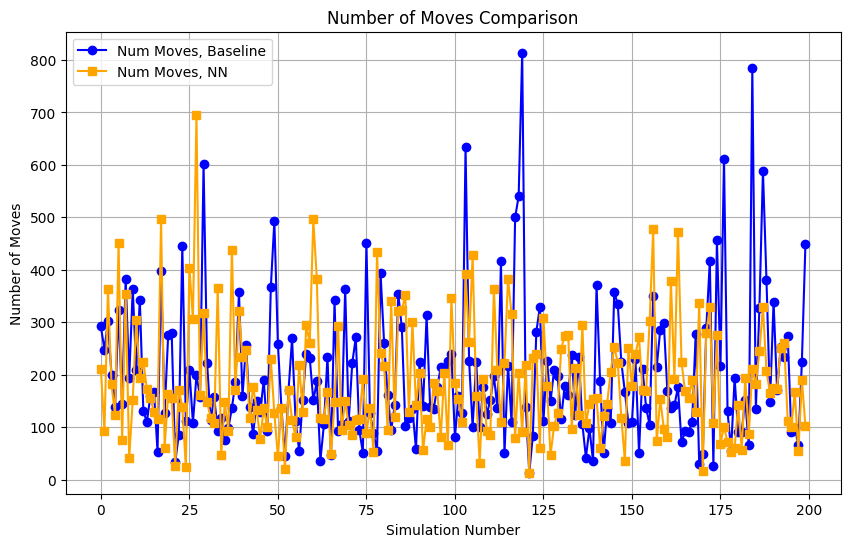

In [135]:
index = list(range(len(num_moves_baseline_list)))

plt.figure(figsize=(10, 6))
plt.plot(index, num_moves_baseline_list, label='Num Moves, Baseline', marker='o', color='blue')
plt.plot(index, num_moves_nn_list, label='Num Moves, NN', marker='s', color='orange')
# plt.yscale("log")
plt.xlabel('Simulation Number')
plt.ylabel('Number of Moves')
plt.title('Number of Moves Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [140]:
print(f"Mean number of moves for baseline: {np.mean(num_moves_baseline_list)}")
print(f"Mean number of moves for NN: {np.mean(num_moves_nn_list)}")
print(f"Percent improvement from baseline: {(np.mean(num_moves_baseline_list) - np.mean(num_moves_nn_list)) / np.mean(num_moves_baseline_list) * 100:.2f}%")

Mean number of moves for baseline: 201.105
Mean number of moves for NN: 186.025
Percent improvement from baseline: 7.50%


# Writeup

## Data Collection, Input and Output

To collect data, we run our bot loop to collect data over 1000 simulations. The bot loop has been augmented such that every time either knowledgebase is updated, it returns a snapshot of the bot position probability grid, the rat position probability grid, and the number of steps taken so far (so that we can calculate the number of steps remaining as number of steps total until the rat is found minus the number of steps so far). This typically collects roughly 22000 data points, which includes data varied enough from all stages of the bot's journey over a variety of different bot and rat starting points on the same grid.

Our model input is a single tensor with dimensions N x 2 x 30 x 30, representing N data points consisting or two 30 x 30 grids representing a given data point's bot and rat probability grids. The contents of these vary depending on the state of the bot's journey in a given iteration.

If phase 1 is ongoing, then the rat probability grid has the value $\frac{1}{\text{number of open cells}}$ for all open cells, and 0 for walls. However, the bot's probability grid will be changing every iteration, as each the cell coordinates for each candidate for where the bot may be/have started at would have a value of $\frac{1}{\text{number of bot spot candidates}}$.
If phase 1 is complete and the bot is in phase 2, however, then the bot probability grid will still reflect the bot's possible locations (which we know). This means the grid would be all zeroes but have a 1 where the bot is at in the iteration. The rat probability grid would have the rat knowledge base at that iteration as well.
This ideally allows the model to draw a spatial connection between probabilities in the rat grid and probabilities in the bot grid.

As for output, as stated above, we keep track of both the number of moves so far in an iteration and the total number of moves in a given run, so that we can calculate the actual number of moves remaining for a given input snapshot. This is simply represented as a N length vector, where each output element in the vector corresponds to one of the N datapoints in the input tensor.

## Model Architecture and Loss function

Because we are working with spatial relationships in a maze-esque problem, we decided to build our model in a Convolutional Neural Network. We use two convolutional layers and three linear fully connected linear layers. All layers and channels were decided upon after much trial and error and analysis, keeping into consideration time and compute constraints.

We decided to expand the number of layers to 32 in the first convolutional layer under the idea that increasing the number of channels from 2, the input, would allow us to better capture compressed features/datapoints. We found that trying 8 or 16 in this layer led to underfitting, and almost always resulted in outputs from the model being a single value. We then tried 32 with success, and then further expanded it to 64 features in our next convolutional layer.

We stuck with the idea of a second layer when experimenting with different numbers of layers and found that a second layer had the best impact on our loss. We found that the higher the number of features we could run with, the more patterns were likely being caught by the model. However, due to time constraints we did not go past 64 output channels.

For the fully connected layers, we simply took a number where we could reasonably decrease the number of features into a single real number output without losing too much important data in one go. We found that this maintained a relatively better test loss without adding too much to our runtime.

We set our kernel window size to three with the default stride of 1 to look at more of the data at once and hopefully generalize segments of the map while also drawing relationships between them. We also learned about pooling when looking into CNN's, and decided to use a max pooling to reduce dimensions and help runtime further while still maintaining important features. These series of decisions are what ultimately led to our current model architecture.

We are using L1 loss for our loss function, and for a couple main reasons. We initially started with MSE, but our bot has very high performance variance and often becomes very confident in cells way far off from the rat. Because we can sometimes end up taking even as many as 400 steps for a rat that's only 50 cells away, we had difficulties getting our model to optimize properly. MAE/L1 loss, however, is less sensitive to such changes and puts an emphasis on aiming for goals that are universally closer to the actual search times. Additionally, since our bot puts emphasis not only on less pings and more steps, it also re-pings and recalculate in the middle of long paths. This only further adds to our variance and in general makes our bot's behavior difficult for a model to predict. So both experimentally and conceptually, we had to lean towards L1 loss as our model's loss function.

## Data Analysis

Training and testing loss went down as expected and hit a plateau. Because there is still some randomness to the bot's movements, we could not get the loss down further without overfitting.
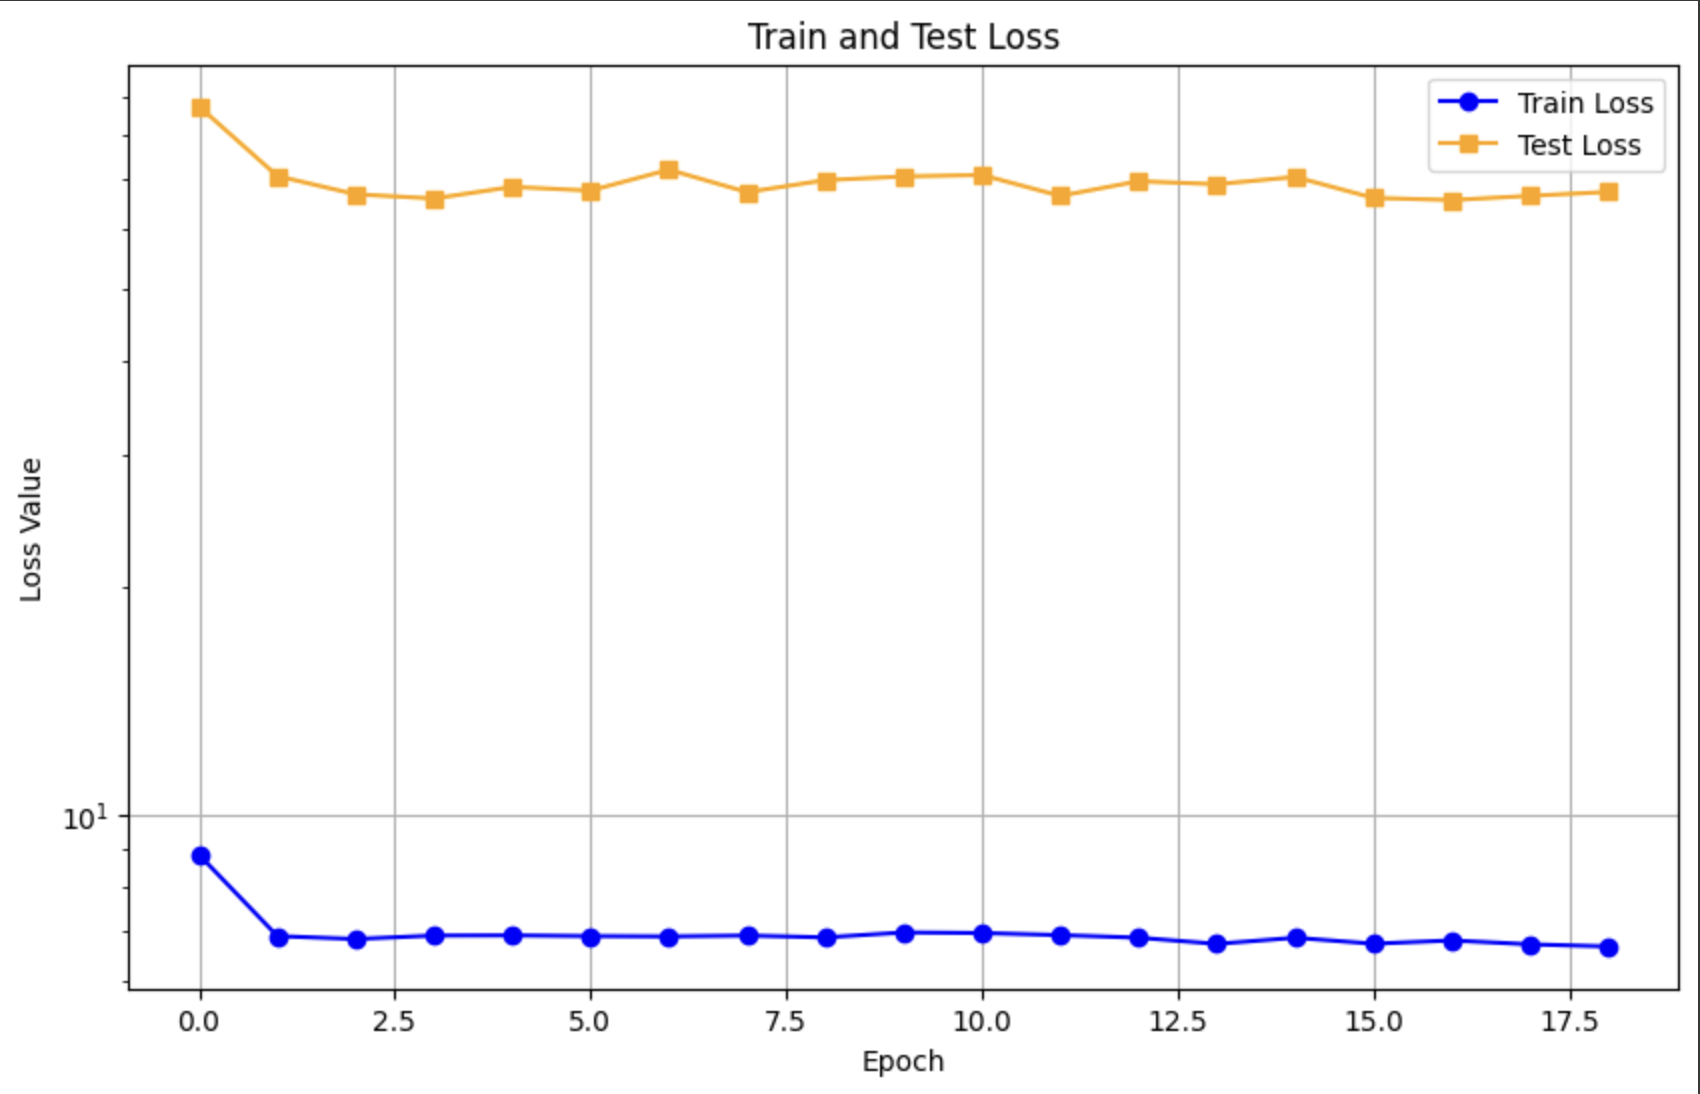

To track loss throughout a simulation, we partitioned each simulation into 15 chunks representing the "stage" of each simulation. As expected, loss went down as the simulation proceeded; however, it went back up briefly at the end. We believe this is because the bot sometimes circles around the rat before catching it, leading to some discrepancy.
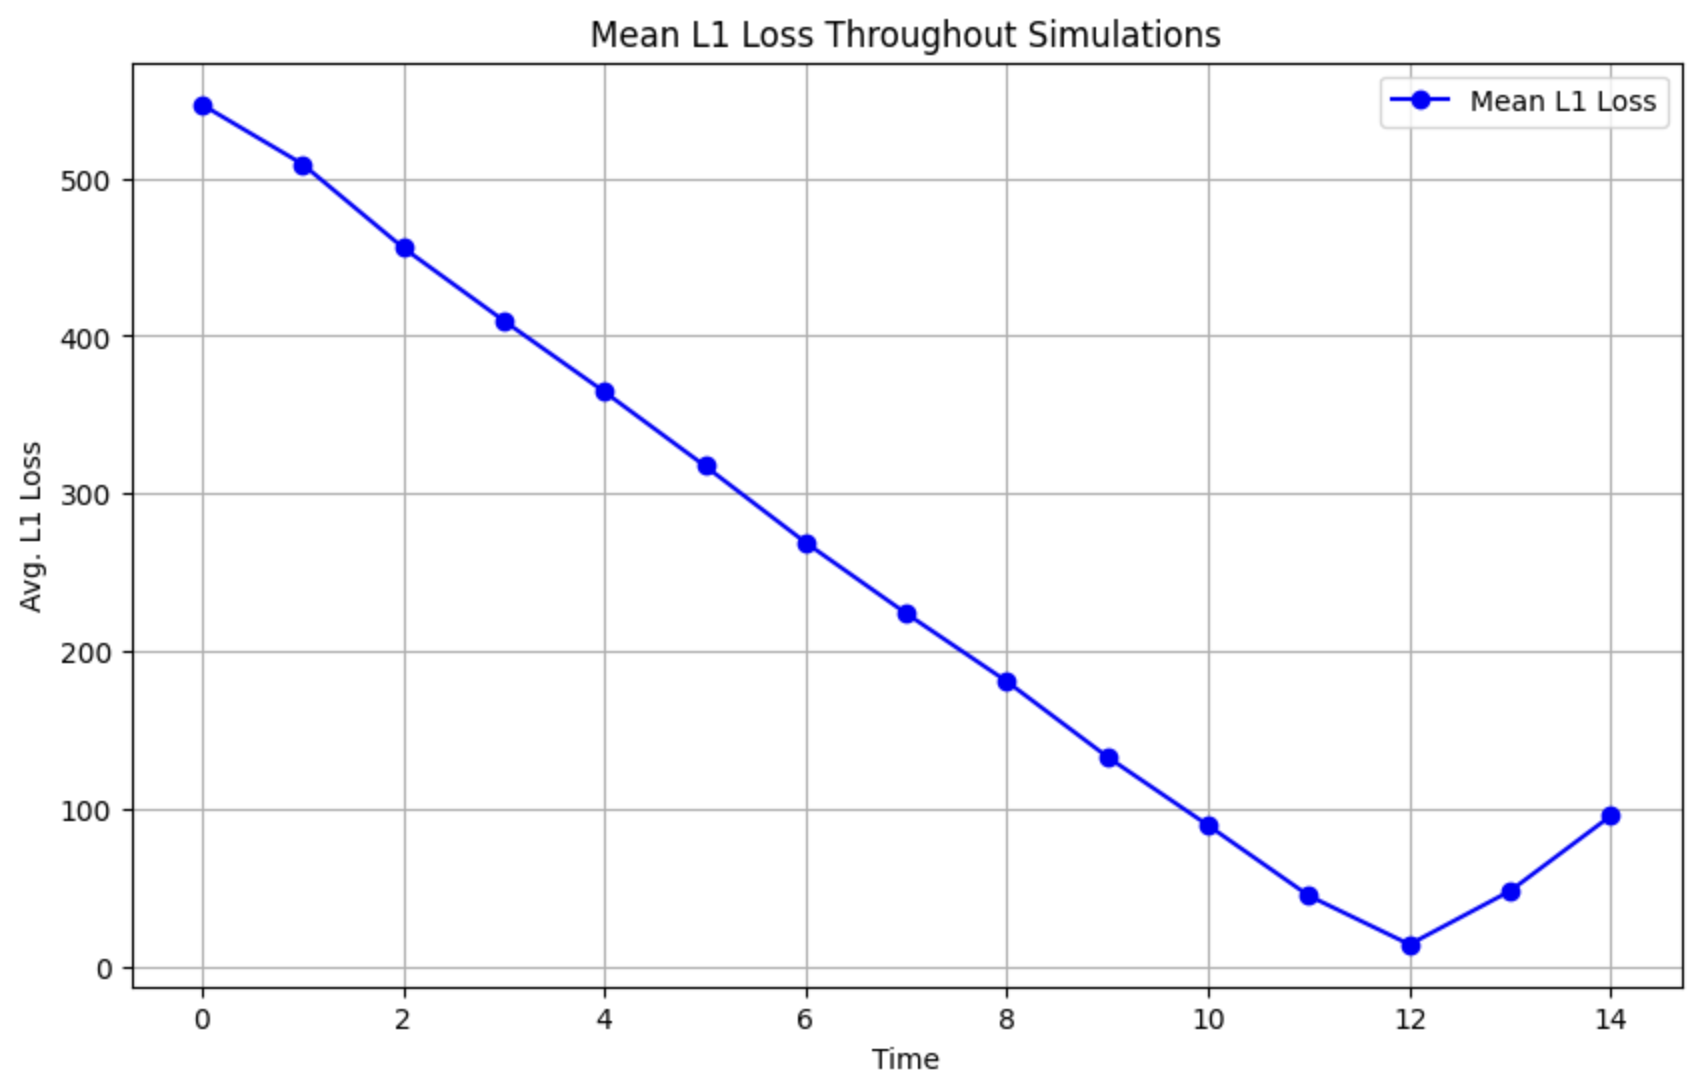


## NN Bot Logic
Our new bot will have a different utility function:
\
$$U(\text{cell}) = \theta_0 p_\text{cell} - \theta_1 d_\text{cell} - 2\sigma\left(5(d-\gamma/2)\right)\left[d-(\gamma/2)^2\right]$$

Where $\gamma=$ the model prediction for number of moves given the current board state, and $\sigma()$ is the sigmoid function. Each time the bot pings in phase 2 and updates probabilities, it will run the model on the current state of the board and use the utility function accordingly. This new utility function should strongly prefer cells that are less than $\gamma/2$ away from the bot. We chose to reduce $\gamma$ to account for the inaccuracy in number of moves remaining (the model tends to overestimate this). We believe that this bot should do best when it is closer to the rat, as it should always prefer closer cells.

The coefficients chosen after significant trial and error were $\theta_0 = 1, \theta_1 = 10^{-8}$.

For the data analysis, we calculated the average number of moves for baseline and for this upgrade and found that our upgrade takes approximately 7.5% less moves on average to find the rat.